<a href="https://colab.research.google.com/github/destaerc/Yverdon_les_tropiques/blob/main/Traitement_Donn%C3%A9es_Decentlab_Meteosuisse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from pytz import timezone

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# === 1. Chargement des fichiers ===


def load_data(folder_path, file_names):
    dfs = {}
    for key, file_name in file_names.items():
        file_path = os.path.join(folder_path, file_name)
        try:
            dfs[key] = pd.read_csv(file_path, sep=";")
            logging.info(f"{file_name} chargé avec succès.")
        except FileNotFoundError:
            logging.error(f"Fichier introuvable : {file_path}")
            return None
        except Exception as e:
            logging.error(f"Erreur lors du chargement de {file_path} : {e}")
            return None
    return dfs


In [2]:
# === 2. Standardisation des colonnes et noms ===
import pandas as pd
import numpy as np

def convert_utc_to_swiss_calendar(dt_series):
    """
    Convertit une série datetime UTC en heure suisse (CET/CEST)
    selon le calendrier des changements d'heure en Europe.
    """
    local_times = []
    for dt in dt_series:
        if pd.isna(dt):
            local_times.append(np.nan)
            continue

        # Calcul des dates de changement d'heure pour l'année courante
        year = dt.year
        # Dernier dimanche de mars
        last_sunday_march = max(pd.date_range(f"{year}-03-01", f"{year}-03-31", freq="D")[pd.date_range(f"{year}-03-01", f"{year}-03-31", freq="D").weekday == 6])
        # Dernier dimanche d'octobre
        last_sunday_oct = max(pd.date_range(f"{year}-10-01", f"{year}-10-31", freq="D")[pd.date_range(f"{year}-10-01", f"{year}-10-31", freq="D").weekday == 6])

        # Application du décalage
        if last_sunday_march <= dt.replace(tzinfo=None) < last_sunday_oct:
            # Heure d'été : UTC+2
            local_times.append(dt + pd.Timedelta(hours=2))
        else:
            # Heure d'hiver : UTC+1
            local_times.append(dt + pd.Timedelta(hours=1))

    return pd.Series(local_times, index=dt_series.index)

def preprocess_data(df1, df2):

    # Dates df1
    df1['datetime'] = pd.to_datetime(df1['heure'], errors='coerce')

    # Conversion MeteoSuisse UTC → Heure suisse basée sur le calendrier
    df2['datetime'] = pd.to_datetime(df2['timestamp'], errors='coerce')
    df2['datetime'] = convert_utc_to_swiss_calendar(df2['datetime'])

    # Sélection et renommage colonnes
    df1_sub = df1[['datetime', 'station', 'temperature', 'humidity']].copy()
    df2_sub = df2[['datetime', 'station_abbr', 'tre200h0', 'rre150h0', 'gre000h0', 'ure200h0']].copy()
    df2_sub.rename(columns={'tre200h0': 'temperature', 'ure200h0': 'humidity'}, inplace=True)

    # Standardisation noms stations df1
    mapping = {
        'cimeti re': 'Cimetière',
        'jardin de poche': 'Jardin de Poche',
        'parc d entremonts': "Parc d'Entremonts",
        'parc des rives': 'Parc des Rives',
        'pierre de savoie': 'Pierre de Savoie',
        'place d arme': "Place d'Arme",
        'place pestalozzi': 'Place Pestalozzi',
        'platane du ch teau': 'Platane du Château',
        'rue de la plaine': 'Rue de la Plaine'
    }
    df1_sub['station'] = df1_sub['station'].str.lower().str.strip()
    df1_sub['station'] = df1_sub['station'].replace(mapping)

    # Ajouter source
    df1_sub['source'] = 'Decentlab'
    df2_sub['source'] = 'MeteoSuisse'

    # Fusionner
    combined = pd.concat([df1_sub, df2_sub], ignore_index=True)

    # Nettoyer
    combined = combined.dropna(subset=['temperature'])
    combined = pd.concat([
        combined[combined['source'] == 'Decentlab'].dropna(subset=['station']),
        combined[combined['source'] == 'MeteoSuisse'].dropna(subset=['station_abbr'])
    ], ignore_index=True)

    return combined

In [3]:
# === 3. Calcul statistiques journalières ===
def daily_temperature_stats(df, station_abbr):
    meteo = df[(df['source'] == 'MeteoSuisse') & (df['station_abbr'] == station_abbr)].copy()
    meteo['date'] = meteo['datetime'].dt.date

    daily_stats = meteo.groupby('date')['temperature'].agg(['min', 'max', 'mean']).reset_index()
    daily_stats.rename(columns={'mean': 'avg'}, inplace=True)
    daily_stats['date'] = pd.to_datetime(daily_stats['date'])
    daily_stats['above_avg_25'] = daily_stats['avg'] > 25
    daily_stats['above_min_20'] = daily_stats['min'] > 20
    daily_stats['above_max_35'] = daily_stats['max'] > 35

    # Combiner les stats pour détection de périodes chaudes
    daily_stats['criteria_met'] = daily_stats[['above_avg_25', 'above_min_20', 'above_max_35']].any(axis=1)
    daily_stats['group'] = (daily_stats['criteria_met'].diff() != 0).cumsum()

    # Filtrer les périodes d'au moins 3 jours consécutifs
    criteria_periods = daily_stats[daily_stats['criteria_met']]
    grouped_periods = criteria_periods.groupby('group').agg(
        start_date=('date', 'min'),
        end_date=('date', 'max'),
        count=('date', 'count')
    ).reset_index()
    heatwaves = grouped_periods[grouped_periods['count'] >= 3]


    return daily_stats, heatwaves

In [4]:
# === 4. Détection périodes > 30°C max sur 3 jours ===
def detect_hot_periods(daily_max_df, threshold=30, min_days=3):
    days_above = daily_max_df[daily_max_df['max'] > threshold].copy()
    days_above['group'] = (days_above['date'].diff().dt.days != 1).cumsum()
    grouped = days_above.groupby('group').agg(
        start_date=('date', 'min'),
        end_date=('date', 'max'),
        count=('date', 'count')
    ).reset_index()
    hot_periods = grouped[grouped['count'] >= min_days]
    return hot_periods

In [5]:
# === 5. Fonction de tracé simplifiée ===
def plot_temperature_with_heatwaves(df, heatwaves, start_date, window_size=3):
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 7))

    # Filtrer données depuis start_date
    df_filtered = df[(df['source'] == 'MeteoSuisse') & (df['station_abbr'] == 'MAH') & (df['datetime'] >= start_date)].copy()
    df_filtered['date'] = df_filtered['datetime'].dt.date


    # Calcul moyenne journalière lissée
    daily_avg = df_filtered.groupby('date')['temperature'].mean().reset_index()
    daily_avg['date'] = pd.to_datetime(daily_avg['date'])
    daily_avg['smoothed'] = daily_avg['temperature'].rolling(window=window_size, center=True).mean()

    plt.plot(df_filtered['datetime'], df_filtered['temperature'], label='Température horaire', color='steelblue', alpha=0.7)
    plt.plot(daily_avg['date'], daily_avg['smoothed'], label=f'Moyenne quotidienne lissée ({window_size}j)', color='red', linestyle='--', linewidth=2)

    # Zones canicule
    canicule_color = (1, 0.6, 0.6, 0.3)
    added_legend = False  # Flag to add legend only once
    for _, row in heatwaves.iterrows():
        if not added_legend:
            plt.axvspan(row['start_date'], row['end_date'], color=canicule_color, label='Température Max journalière > 30°C durant 3 jours consécutifs')
            added_legend = True
        else:
            plt.axvspan(row['start_date'], row['end_date'], color=canicule_color)

        plt.text(row['start_date'], plt.ylim()[0] + 0.02 * (plt.ylim()[1] - plt.ylim()[0]), row['start_date'].strftime('%d.%m'), rotation=90, va='bottom', ha='center', color='darkred', fontsize=9)
        plt.text(row['end_date'], plt.ylim()[0] + 0.02 * (plt.ylim()[1] - plt.ylim()[0]), row['end_date'].strftime('%d.%m'), rotation=90, va='bottom', ha='center', color='darkred', fontsize=9)


    plt.title("Température à la station MAH (Meteo Suisse) - été 2025", fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Température (°C)', fontsize=12)
    plt.legend()
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))
    plt.xticks(rotation=0, ha='center', fontsize=10) # Decrease font size here
    plt.tight_layout()
    plt.show()

In [6]:
# === 6. Fonction de tracé multi-panneau ===
def plot_multi_panel(combined_df, df2, start_date, end_date):
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True, gridspec_kw={'height_ratios': [1, 3, 1, 1]})

    # Filter data for plotting
    placepestalozzi_df_filtered = combined_df[(combined_df['source'] == 'Decentlab') & (combined_df['station'] == "Place d'Arme")].copy()
    placepestalozzi_df_filtered = placepestalozzi_df_filtered[(placepestalozzi_df_filtered['datetime'] >= start_date) & (placepestalozzi_df_filtered['datetime'] <= end_date)].copy()

    meteo_df_filtered = combined_df[(combined_df['source'] == 'MeteoSuisse') & (combined_df['station_abbr'] == 'MAH')].copy()
    meteo_df_filtered = meteo_df_filtered[(meteo_df_filtered['datetime'] >= start_date) & (meteo_df_filtered['datetime'] <= end_date)].copy()

    # Need to join df2 with meteo_df_filtered to get radiation and precipitation columns
    meteo_df_filtered_full = pd.merge(meteo_df_filtered, df2[['datetime', 'rre150h0', 'gre000h0']], on='datetime', how='left')

    # Calculate temperature difference
    # Ensure both dataframes have the same datetime index for accurate subtraction
    temp_diff_df = pd.merge(placepestalozzi_df_filtered[['datetime', 'temperature']], meteo_df_filtered[['datetime', 'temperature']], on='datetime', suffixes=('_placepestalozzi', '_meteo'))
    temp_diff_df['temperature_difference'] = temp_diff_df['temperature_placepestalozzi'] - temp_diff_df['temperature_meteo']

    # Plot Radiation on the first subplot
    sns.lineplot(x='datetime', y='gre000h0_y', data=meteo_df_filtered_full, ax=axes[0], color='orange')
    axes[0].fill_between(meteo_df_filtered_full['datetime'], meteo_df_filtered_full['gre000h0_y'], color='orange', alpha=0.3)
    axes[0].set_ylabel('Radiation (W/m²)')
    axes[0].set_title('Radiation (Station Meteosuisse Mathod)')

    # Plot Temperature on the second subplot
    sns.lineplot(x='datetime', y='temperature', data=placepestalozzi_df_filtered, label='Place Pestalozzi', ax=axes[1])
    sns.lineplot(x='datetime', y='temperature', data=meteo_df_filtered, label='Station Meteosuisse Mathod', ax=axes[1], linewidth=2.5)
    axes[1].set_ylabel('Temperature (°C)')
    axes[1].set_title('Temperature Comparison')
    axes[1].legend()

    # Plot Temperature Difference on the third subplot
    axes[2].fill_between(temp_diff_df['datetime'], temp_diff_df['temperature_difference'], where=(temp_diff_df['temperature_difference'] > 0), color='red', alpha=0.3, interpolate=True)
    axes[2].fill_between(temp_diff_df['datetime'], temp_diff_df['temperature_difference'], where=(temp_diff_df['temperature_difference'] < 0), color='blue', alpha=0.3, interpolate=True)
    axes[2].set_ylabel('Temperature Difference (°C)')
    axes[2].set_title('Temperature Difference (Place Pestalozzi - Station Meteosuisse Mathod)')

    # Plot Precipitation on the fourth subplot using bars
    axes[3].bar(meteo_df_filtered_full['datetime'], meteo_df_filtered_full['rre150h0_y'], color='red', width=0.02)
    axes[3].set_ylabel('Precipitation (mm/h)')
    axes[3].set_title('Precipitation (Station Meteosuisse Mathod)')

    # Add vertical dashed lines at noon and midnight for all subplots
    date_range = pd.date_range(start=start_date.date(), end=end_date.date(), freq='D')
    for date in date_range:
        noon_time = date + pd.Timedelta(hours=12)
        if noon_time <= end_date:
            for ax in axes:
                ax.axvline(noon_time, color='gray', linestyle='--', linewidth=0.8)
        midnight_time = date
        for ax in axes:
            ax.axvline(midnight_time, color='gray', linestyle='-', linewidth=1.5)

    # Format the x-axis
    for ax in axes:
        ax.xaxis.set_major_locator(mdates.HourLocator(byhour=[0, 12]))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m \n%H:%M'))

    fig.suptitle(f'Decentlab Place Pestalozzi vs Station Meteosuisse Mathod from {start_date.date()} to {end_date.date()}', y=1.02)
    plt.xlabel('Time')
    plt.tight_layout()
    plt.show()

INFO: decentlab_moyennes_horaires.csv chargé avec succès.
INFO: meteo_suisse_MAH.csv chargé avec succès.


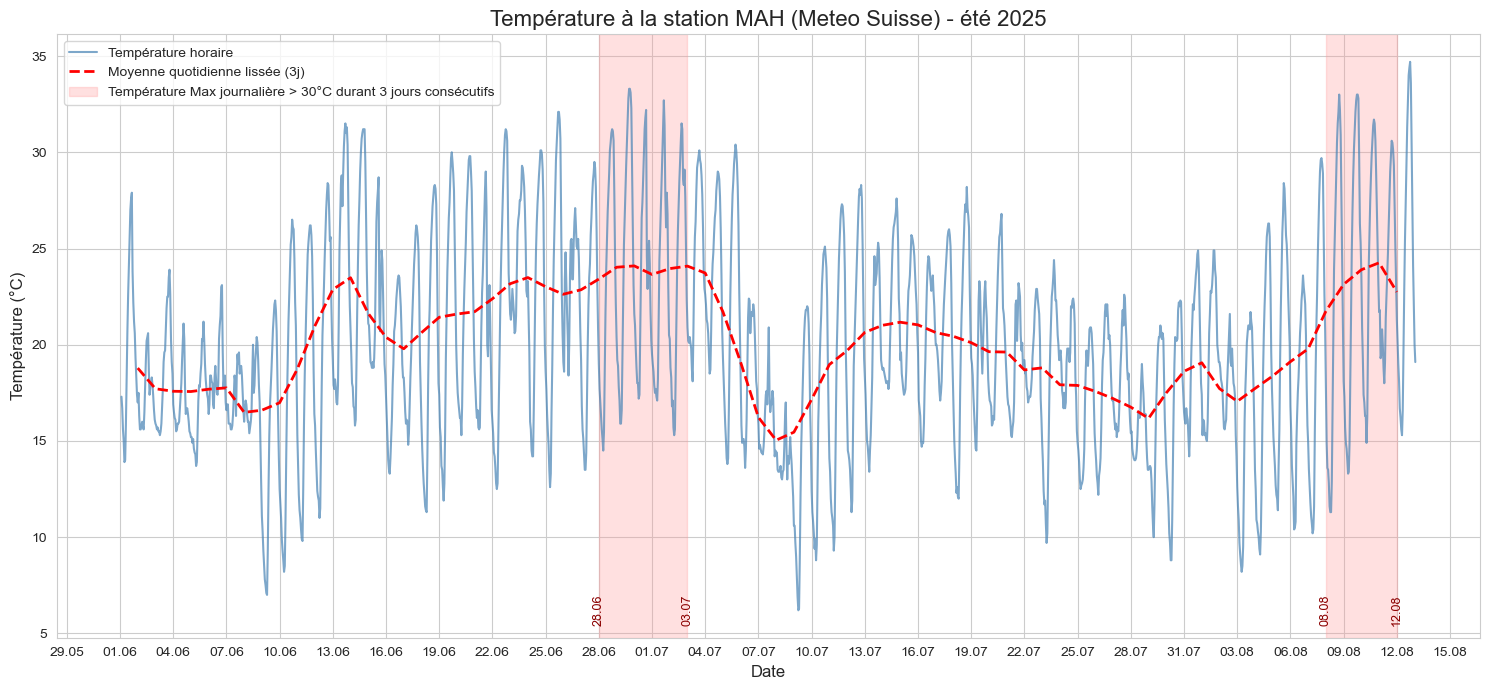

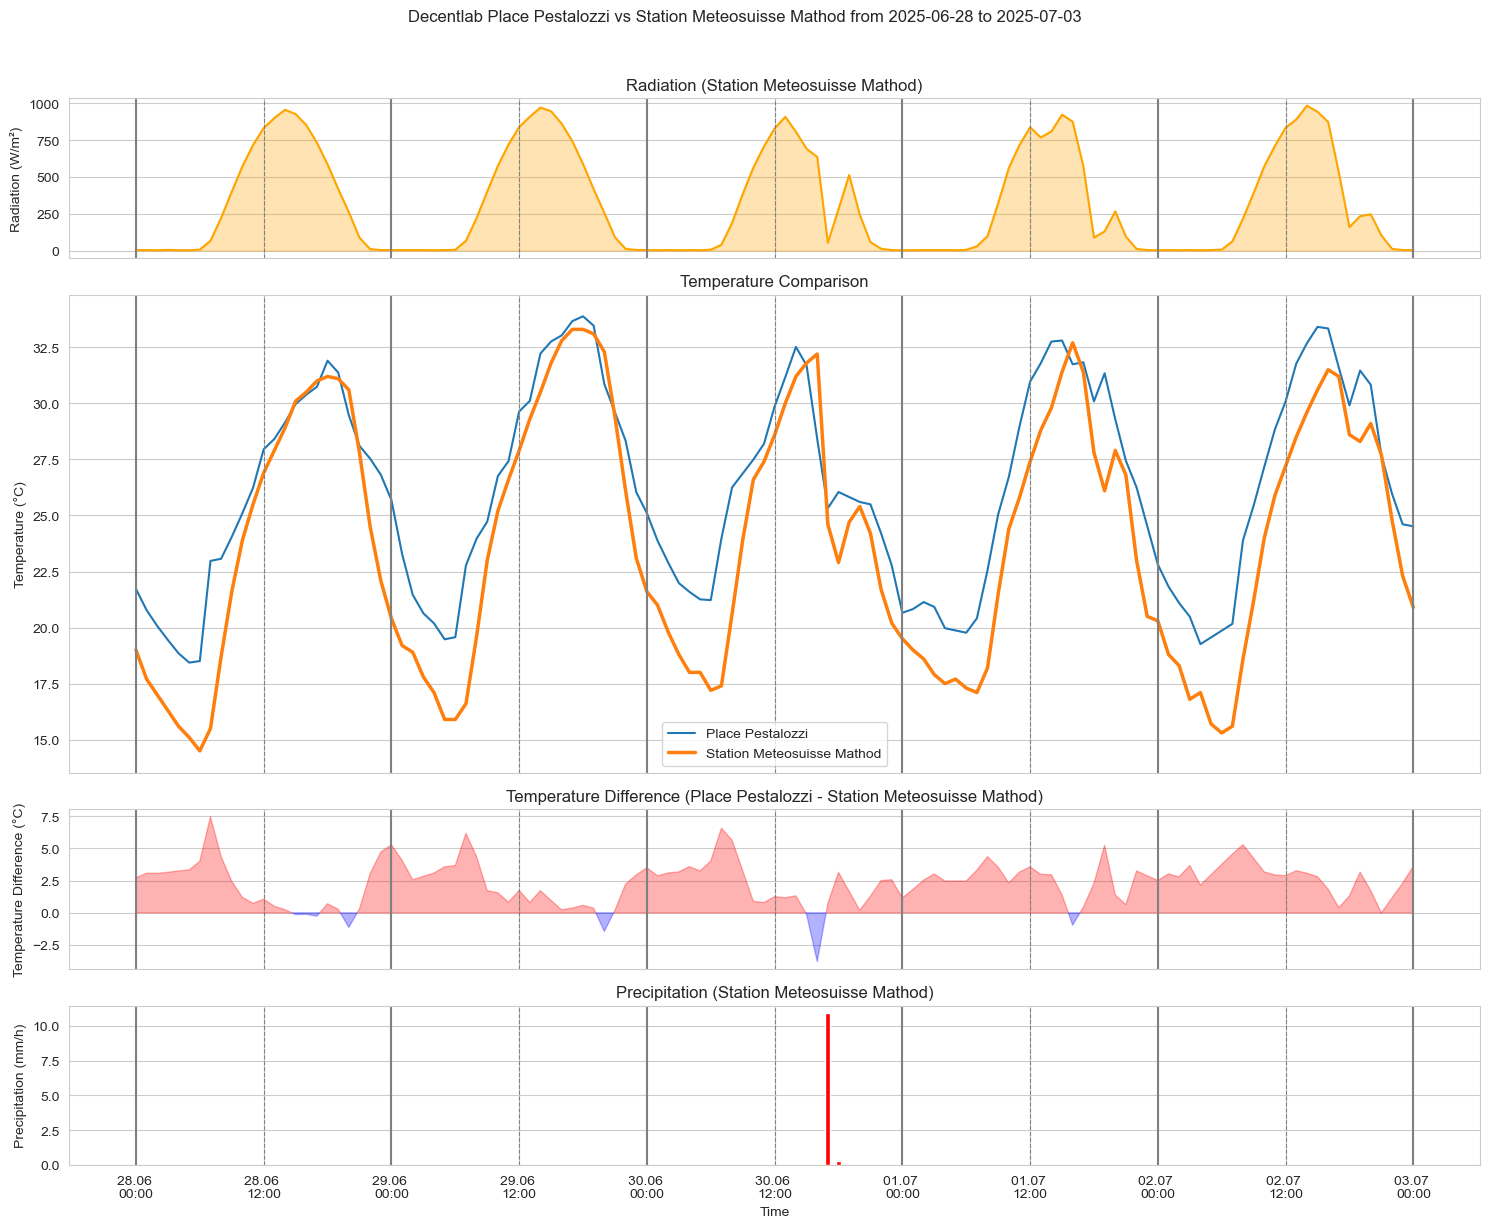

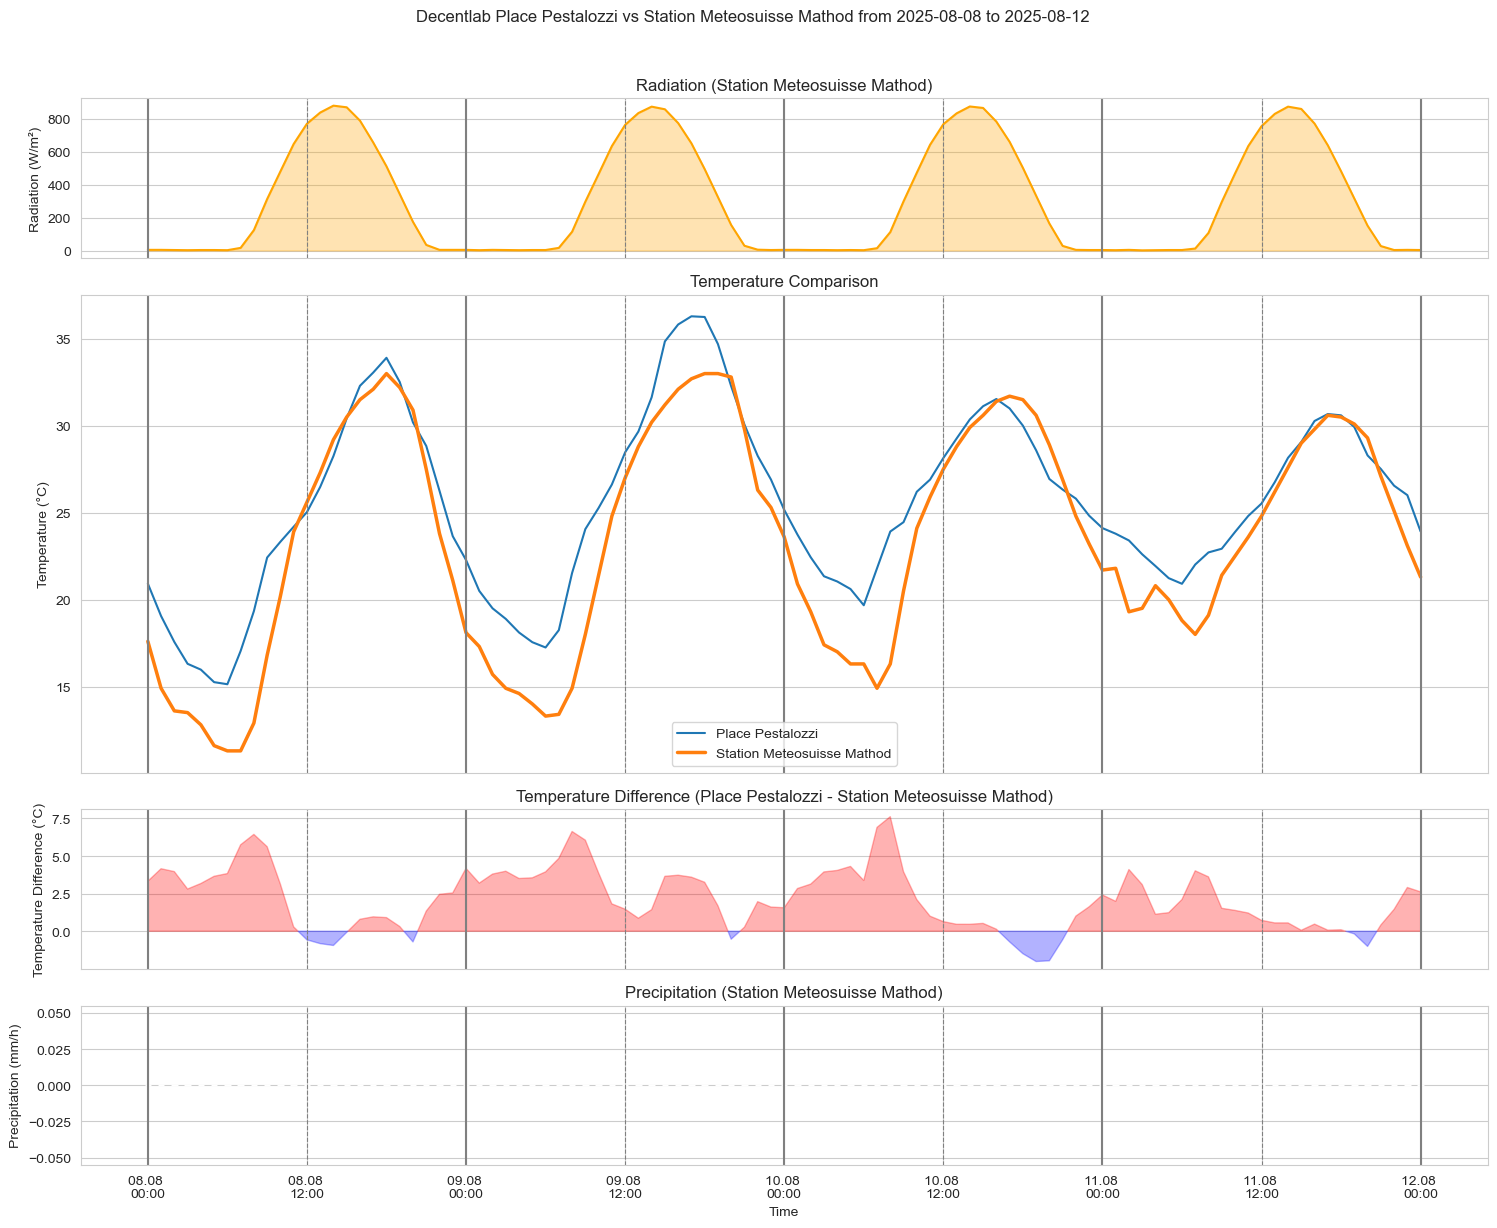

In [7]:
# === === UTILISATION === ===

folder = r'C:\Users\vincent.destaerc\Documents\GitHub\Yverdon_les_tropiques\Export csv'
files = {
    'df1': 'decentlab_moyennes_horaires.csv',
    'df2': 'meteo_suisse_MAH.csv'
}
dfs = load_data(folder, files)

if dfs is not None:
    combined_df = preprocess_data(dfs['df1'], dfs['df2'])

    # Calculate daily temperature statistics for station 'MAH'
    daily_stats_mah, heatwaves_mah = daily_temperature_stats(combined_df, 'MAH')

    # Detect hot periods with a threshold of 30 degrees Celsius for at least 3 days
    hot_periods_mah = detect_hot_periods(daily_stats_mah, threshold=30, min_days=3)

    # Plot the first graph
    start_date_plot1 = pd.to_datetime('2025-06-01')
    plot_temperature_with_heatwaves(combined_df, hot_periods_mah, start_date_plot1)

    # Plot the third and fourth graphs for each hot period
    for index, row in hot_periods_mah.iterrows():
        start_date_period = row['start_date']
        end_date_period = row['end_date']
        plot_multi_panel(combined_df, dfs['df2'], start_date_period, end_date_period)

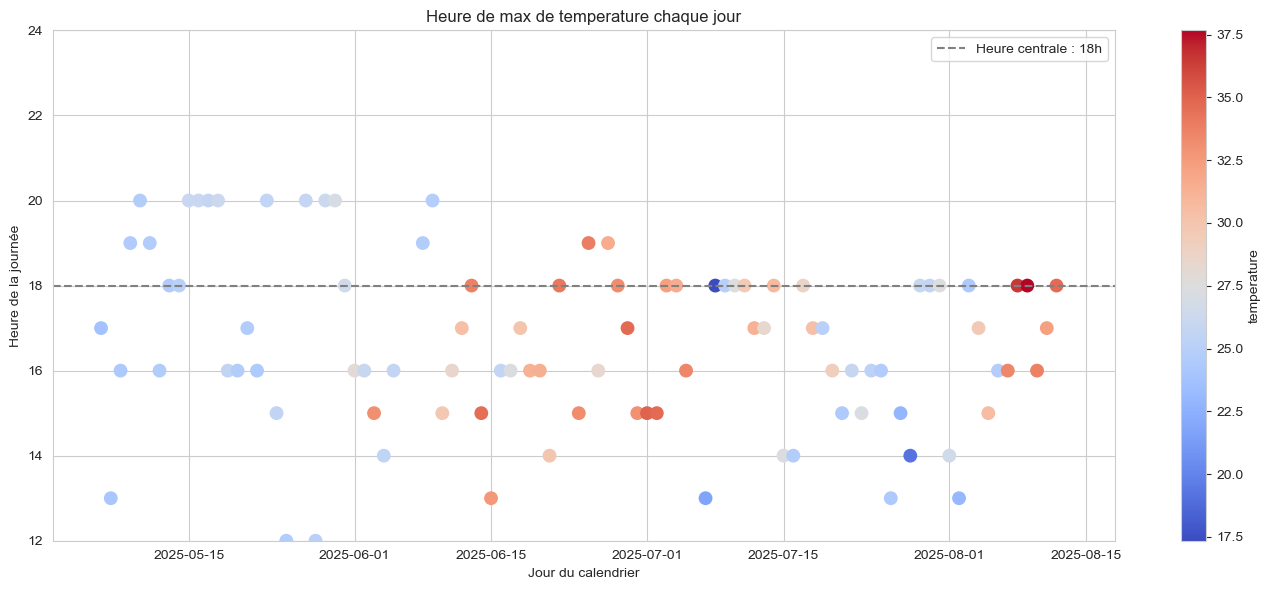